In [1]:
from generate_maps import load_s3dis_point_cloud, get_topologial_map

file_path = 'data/noXYZ_area_3_no_xyz/area_3/3d/pointcloud.mat'  
point_sum_points, point_sum_colors, scene_names = load_s3dis_point_cloud(file_path)
print("success load!")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Keys in the .mat file: ['Area_3']
Processing conferenceRoom_1...
Processing hallway_1...
Processing hallway_2...
Processing hallway_3...
Processing hallway_4...
Processing hallway_5...
Processing hallway_6...
Processing lounge_1...
Processing lounge_2...
Processing office_1...
Processing office_2...
Processing office_3...
Processing office_4...
Processing office_5...
Processing office_6...
Processing office_7...
Processing office_8...
Processing office_9...
Processing office_10...
Processing storage_1...
Processing storage_2...
Processing WC_1...
Processing WC_2...
success load!


In [2]:
import generate_maps
import importlib
importlib.reload(generate_maps)

top_view_map, obstacle_map, separate_obstacle_map, all_centers = generate_maps.get_top_view_map(point_sum_points, point_sum_colors, scene_names)


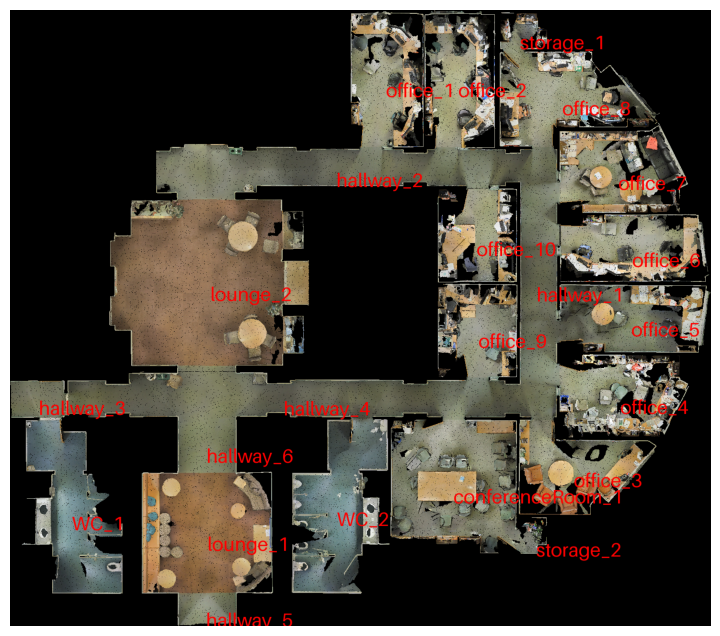

(1287, 1463, 3)


In [3]:
import path_finding
importlib.reload(path_finding)
import matplotlib.pyplot as plt

img = path_finding.write_scene_name(top_view_map, all_centers)
plt.figure(figsize=(10, 8)) 
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.show()
print(top_view_map.shape)

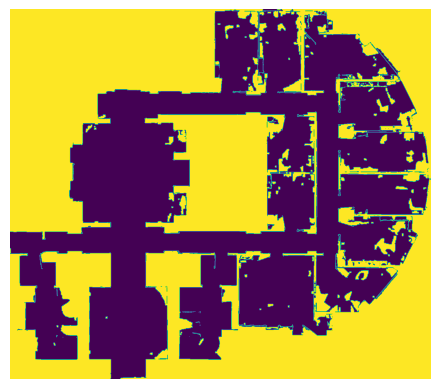

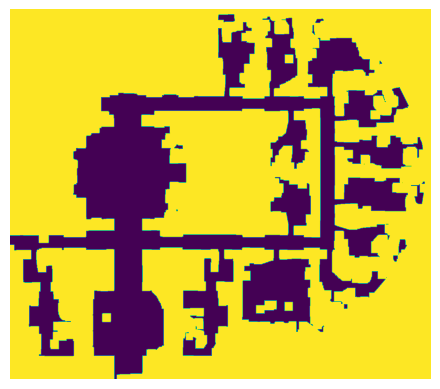

In [4]:
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(25, 25))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)


plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [5]:

# build topo map
# G = get_topologial_map(point_sum_points, scene_names)
# graph_show(G)


success load!


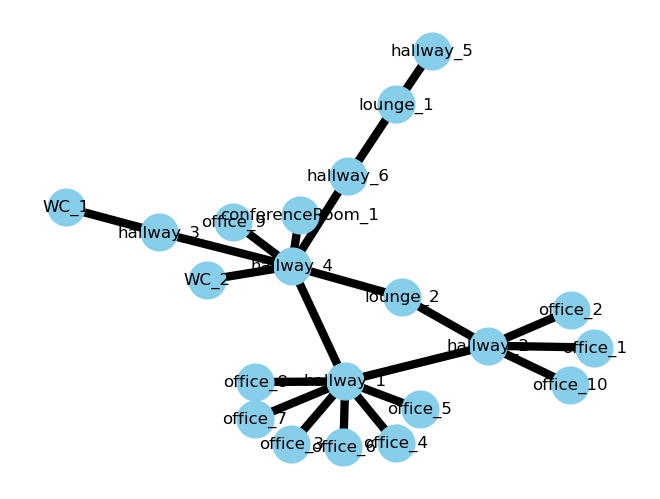

In [6]:
import os
import numpy as np
import pickle

filename = "3"

# print('Saving model to {}...'.format("saved_maps/"))
# if not os.path.exists("saved_maps/"):
#     os.makedirs("saved_maps/")
    
# graph_serialized = pickle.dumps(G)
# np.savez("saved_maps/" + filename +'_arrays.npz', graph=graph_serialized)
# print('Finished.')

file_path = f"saved_maps/{filename}_arrays.npz"  
data = np.load(file_path, allow_pickle=True)
graph_serialized = data['graph'].item()
G_loaded = pickle.loads(graph_serialized)
print("success load!")

path_finding.graph_show(G_loaded)

In [7]:
import networkx as nx
import cv2
import numpy as np
from io import BytesIO

importlib.reload(path_finding)

# all possible topo path searching

def get_all_candidate_maps(source_node, target_node):
    all_topo_paths = path_finding.get_all_simple_paths(G_loaded, source_node, target_node)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph(all_topo_paths, obstacle_map, all_centers)

    save_directory = f"map_with_path/area_{filename}/{source_node}-{target_node}/"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # show paths in map
    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = top_view_map.copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number(map_with_path, i)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像.
        map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    return candidate_map_list, all_geo_paths

In [8]:
importlib.reload(path_finding)
from PIL import Image

def get_metric(source_node, target_node, all_geo_paths):
    evaluation_map = path_finding.get_evaulation_map(separate_obstacle_map, source_node, target_node, scene_names, 15)

    office_obstacle_map_array = np.array(separate_obstacle_map)
    office_obstacle_map = np.max(office_obstacle_map_array, axis=0)

    # evaluation_map = Image.fromarray(evaluation_map)
    # evaluation_map.save(save_directory+f"metric.png")
    # plt.imshow(evaluation_map)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()

    # plt.imshow(gaussian_modulation)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()
    privacy_value_list = []
    distance_list = []
    for i, geo_path in enumerate(all_geo_paths):
        x_indices, y_indices = zip(*geo_path)
        # print(gaussian_modulation[x_indices[0], y_indices[0]])
        print(sum(evaluation_map[x_indices, y_indices]))
        print("distance: ", len(geo_path))
        privacy_value_list.append(sum(evaluation_map[x_indices, y_indices]))
        distance_list.append(len(geo_path))
        
    return privacy_value_list, distance_list

All paths from node office_1 to node office_3 :
2 ['office_1', 'office_3']
4 ['office_1', 'lounge_2', 'hallway_4', 'office_3']
2
['office_1', 'office_3']
['office_1', 'lounge_2', 'hallway_4', 'office_3']


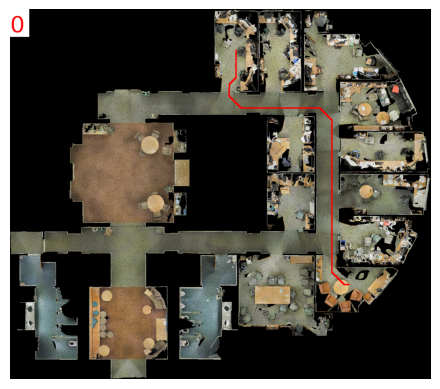

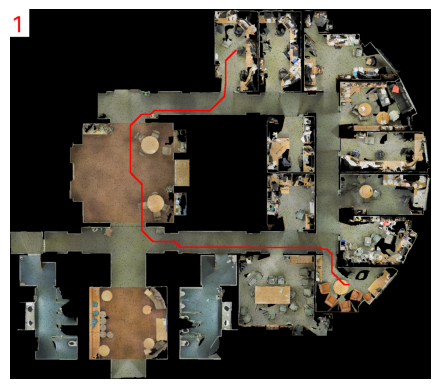

689.8301491009724
distance:  1105
277.34971503534507
distance:  1637
gpt-4o response: 
{
    "observation": "The task involves analyzing two paths for sending an emergency file between offices. Path 0 goes through a series of office spaces and a large open area before reaching the destination. Path 1 also navigates through office areas but takes a slightly different route, passing through a central open area and then through more office spaces.",
    "reason": "Path 0 should be selected because it involves less interaction with clustered office areas compared to Path 1, potentially reducing the disturbance to more employees. Path 0 also appears to utilize larger open areas which might help in quicker and less disruptive transit. Path 1, while similar, passes through central office areas where more human activity might be concentrated, increasing the risk of delays or interruptions.",
    "self-critique": "The decision heavily relies on the assumption that less densely populated office 

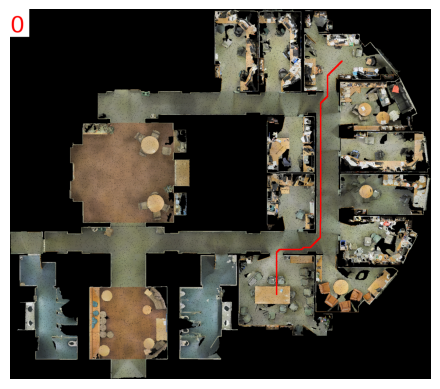

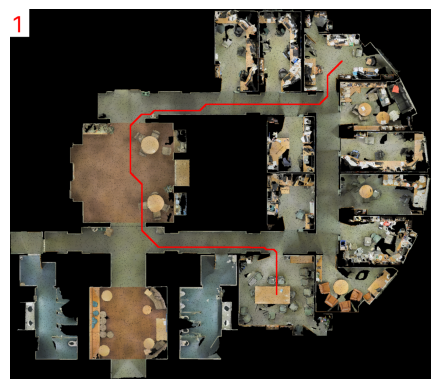

472.8240978532047
distance:  912
468.7896386865141
distance:  1789
gpt-4o response: 
{
    "observation": "The task involves selecting the most efficient and secure path for transporting an emergency file between offices. Path 0 is more direct, passing through fewer office areas, which may reduce the chance of human interaction and potential delays. Path 1, while slightly longer, also avoids most office areas but includes more turns and passes through a central open area which could be busier or less secure.",
    "reason": "Path 0 should be selected because it provides a more direct route, which is crucial in an emergency situation. It minimizes the distance and potential interactions with people, thus ensuring a quicker and safer delivery of the emergency file. Path 1, although viable, is longer and the additional turns and central open area passage might contribute to delays or increased exposure.",
    "self-critique": "While the decision prioritizes speed and minimal human interac

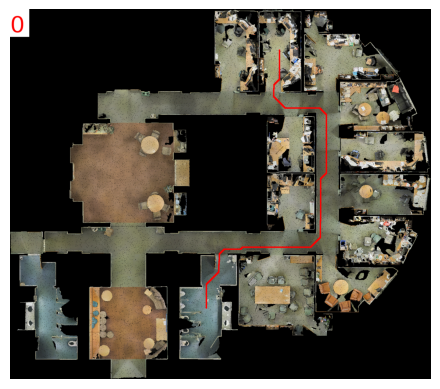

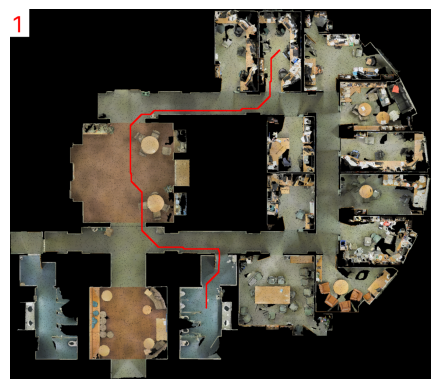

714.4052994245621
distance:  1311
194.83149911191953
distance:  1482
gpt-4o response: 
{
    "observation": "The two provided maps show different paths through an office layout. Path 0 travels through the middle of the office, passing by several workstations and common areas before reaching the destination. Path 1, in contrast, skirts the perimeter of the office areas, passing through fewer workstations and potentially encountering less human activity.",
    "reason": "For the task of sending an emergency file between offices, Path 1 should be selected because it minimizes interaction with crowded office areas and reduces the likelihood of human interference or delays. Path 0, while direct, passes through many active work zones which could compromise the urgency and privacy required for an emergency file transfer.",
    "self-critique": "While Path 1 is longer, the decision prioritizes the need for a secure and less disruptive route over the shortest distance. This choice assumes minim

In [9]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)

num_samples = 5
navigation_instruct1 = "send a secret file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"
navigation_instruct4 = "send an emergency file from an office to another office"

source_nodes = ["office_1", "office_8", "office_2"]
target_nodes = ["office_3", "conferenceRoom_1", "WC_2"]

total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)
    p_v, dis = get_metric(source_node, target_node, all_geo_paths)
    
    index = dis.index(min(dis))
    total_shortest_score += p_v[index]
    total_shortest_distance += dis[index]
    
    navigation_instruct = navigation_instruct1
    if "conference" in target_node:
        navigation_instruct = navigation_instruct2
    elif "WC" in target_node:
        navigation_instruct = navigation_instruct3
    message = chat_utils.message_prepare(system_prompt.prompt, candidate_map_list, navigation_instruct)
            
    response_message = chat_utils.chat_with_gpt4v(message)
    ground_json = ast.literal_eval(response_message)
    print(ground_json["path_id"])
    index = int(ground_json["path_id"])
    
    # responses = []
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #     future_to_message = {executor.submit(chat_utils.chat_with_gpt4v, message): message for _ in range(num_samples)}
    #     for future in concurrent.futures.as_completed(future_to_message):
    #         prompt = future_to_message[future]
    #         try:
    #             response = future.result()
    #             responses.append(response)
    #         except Exception as exc:
    #             print(f'{prompt} generated an exception: {exc}')

    # id_list = []
    # for i, response in enumerate(responses):
    #     ground_json = ast.literal_eval(response)
    #     id_list.append(int(ground_json["path_id"])) 
    # print(id_list)
            
    # counter = Counter(id_list)

    # index, count = counter.most_common(1)[0]
    total_privacy_score += p_v[index]
    total_privacy_distance += dis[index]
    
    
print("A* baseline result: ")
print("total_shortest_score: ", total_shortest_score)
print("total_shortest_distance: ", total_shortest_distance)

print("PAN baseline result: ")
print("total_privacy_score: ", total_privacy_score)
print("total_privacy_distance: ", total_privacy_distance)
    
    